In [1]:
#!pip install backtrader

In [2]:
from datetime import datetime
import backtrader as bt
import matplotlib

matplotlib.__version__

'3.2.2'

In [3]:
cerebro = bt.Cerebro()

In [4]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    
    params = (
        ('maperiod', 34),
    )

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        # To keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.ExponentialMovingAverage(self.datas[0], period=self.params.maperiod)

    def log(self, txt, dt=None):
        '''Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Comm {order.executed.comm}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm 
            elif order.issell():
                self.log(f'SELL EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Comm {order.executed.comm}')
    
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Reset order status to prepare for next order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION PROFIT, GROSS: {trade.pnl}, NET: {trade.pnlcomm}')

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'Close, {self.dataclose[0]}')

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log(f'BUY CREATE, {self.dataclose[0]}')

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log(f'SELL CREATE, self.dataclose[0]')

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [5]:
# Add a strategy
cerebro.addstrategy(TestStrategy)

0

In [6]:
data = bt.feeds.YahooFinanceData(dataname='^NSEI', fromdate=datetime(2020, 1, 1),
                                  todate=datetime(2021, 2, 16))
cerebro.adddata(data)

In [7]:
cerebro.broker.setcash(10_00_000.0)

In [8]:
# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=3) #buy/sell 3 futures

In [9]:
# Set the commission - Rs 20 per transcation
cerebro.broker.setcommission(commission=20, margin=1_70_000)

In [10]:
starting = cerebro.broker.getvalue()
print(f'Starting Portfolio Value: {starting}')

Starting Portfolio Value: 1000000.0


In [11]:
%%time
cerebro.run()

2020-02-17, Close, 12045.8
2020-02-18, Close, 11992.5
2020-02-19, Close, 12125.9
2020-02-20, Close, 12080.85
2020-02-24, Close, 11829.4
2020-02-25, Close, 11797.9
2020-02-26, Close, 11678.5
2020-02-27, Close, 11633.3
2020-02-28, Close, 11201.75
2020-03-02, Close, 11132.75
2020-03-03, Close, 11303.3
2020-03-04, Close, 11251.0
2020-03-05, Close, 11269.0
2020-03-06, Close, 10989.45
2020-03-09, Close, 10451.45
2020-03-11, Close, 10458.4
2020-03-12, Close, 9590.15
2020-03-13, Close, 9955.2
2020-03-16, Close, 9197.4
2020-03-17, Close, 8967.05
2020-03-18, Close, 8468.8
2020-03-19, Close, 8263.45
2020-03-20, Close, 8745.45
2020-03-23, Close, 7610.25
2020-03-24, Close, 7801.05
2020-03-25, Close, 8317.85
2020-03-26, Close, 8641.45
2020-03-27, Close, 8660.25
2020-03-30, Close, 8281.1
2020-03-31, Close, 8597.75
2020-04-01, Close, 8253.8
2020-04-03, Close, 8083.8
2020-04-07, Close, 8792.2
2020-04-08, Close, 8748.75
2020-04-09, Close, 9111.9
2020-04-13, Close, 8993.85
2020-04-15, Close, 8925.3
2020-

In [12]:
ending = cerebro.broker.getvalue()
print(f'Final Portfolio Value: {ending}')

Final Portfolio Value: 1013217.85


In [13]:
print(f'Returns: {round(((ending - starting)/starting)*100, 2)}%')

Returns: 1.32%


<IPython.core.display.Javascript object>


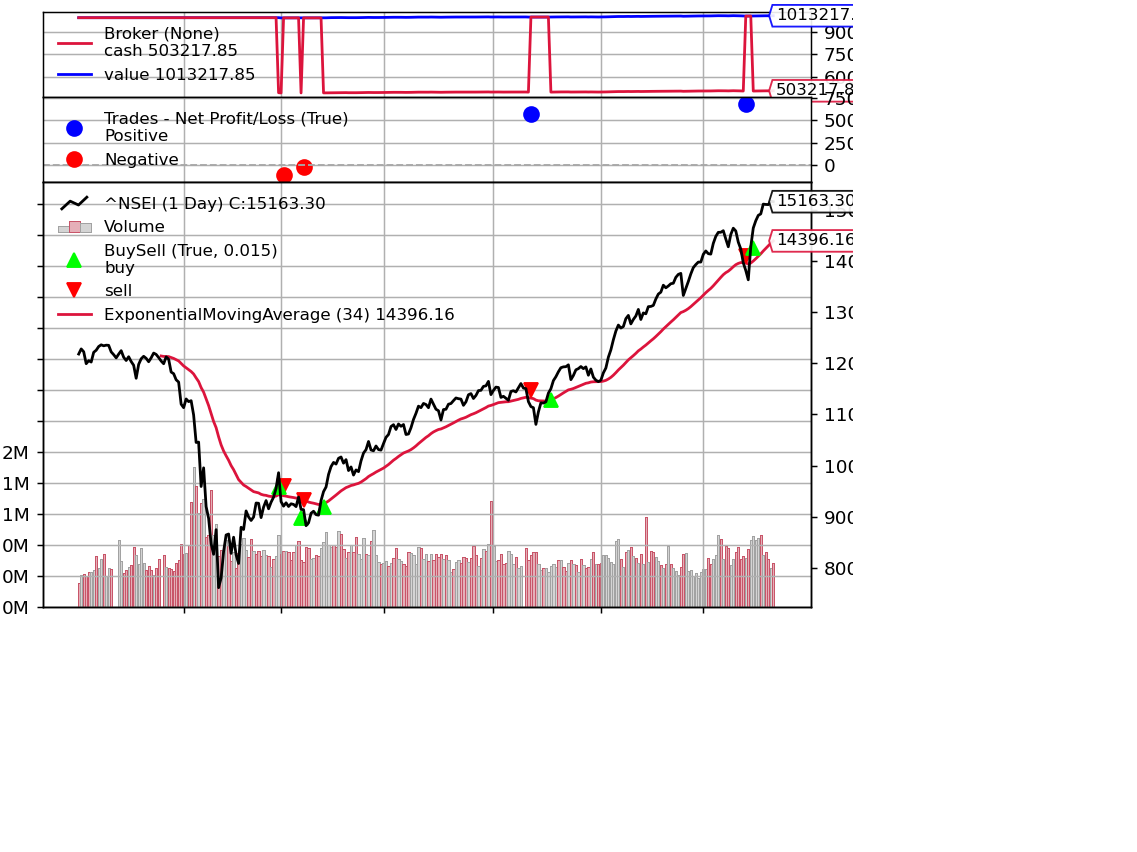

[[<Figure size 640x480 with 4 Axes>]]

In [14]:
cerebro.plot()